In [1]:
from keras import layers
import tensorflow as tf
import keras

In [2]:
import numpy as np

x = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\freq_data_1_sec_force_quality_plus_t\x_for_ltsm.npy")
y = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\freq_data_1_sec_force_quality_plus_t\y_for_ltsm.npy")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

signal_x_train = x_train[:, :-1]
signal_x_test = x_test[:, :-1]
temp_x_train = x_train[:, -1]
temp_x_test = x_test[:, -1]

In [4]:
# create and fit the LSTM network it has two inputs, freq dataseries and temperature
time_input = keras.layers.Input(shape=(129, 1))
temp_input = keras.layers.Input(shape=(1,))

lstm = layers.LSTM(64, input_shape=(129, 1))(time_input)
dense0 = keras.layers.Dense(1, activation="relu")(temp_input)

merged = keras.layers.Concatenate(axis=1)([lstm, dense0])

dense1 = keras.layers.Dense(128, activation="relu")(merged)
drop_out_1 = layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(128, activation="relu")(drop_out_1)
drop_out_2 = layers.Dropout(0.2)(dense2)

output = keras.layers.Dense(13, activation="softmax")(drop_out_2)

model = keras.models.Model(inputs=[time_input, temp_input], outputs=output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 129, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           16896       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1)            2           ['input_2[0][0]']                
                                                                                              

In [5]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
# Compile the model.
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc")
    ],
)

In [6]:
batch_size = 128
num_epochs = 500

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
# Fit the model.
history = model.fit(
    x=[signal_x_train, temp_x_train],
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=2,
)


Epoch 1/500
1342/1342 - 18s - loss: 1.8617 - acc: 0.3720 - val_loss: 1.2740 - val_acc: 0.5326 - 18s/epoch - 13ms/step
Epoch 2/500
1342/1342 - 14s - loss: 1.1987 - acc: 0.5494 - val_loss: 1.0013 - val_acc: 0.6168 - 14s/epoch - 11ms/step
Epoch 3/500
1342/1342 - 14s - loss: 0.9949 - acc: 0.6158 - val_loss: 0.8410 - val_acc: 0.6791 - 14s/epoch - 11ms/step
Epoch 4/500
1342/1342 - 14s - loss: 0.8414 - acc: 0.6774 - val_loss: 0.6897 - val_acc: 0.7420 - 14s/epoch - 11ms/step
Epoch 5/500
1342/1342 - 15s - loss: 0.6875 - acc: 0.7424 - val_loss: 0.5458 - val_acc: 0.7996 - 15s/epoch - 11ms/step
Epoch 6/500
1342/1342 - 15s - loss: 0.5595 - acc: 0.7938 - val_loss: 0.4616 - val_acc: 0.8310 - 15s/epoch - 11ms/step
Epoch 7/500
1342/1342 - 14s - loss: 0.4690 - acc: 0.8275 - val_loss: 0.3883 - val_acc: 0.8571 - 14s/epoch - 11ms/step
Epoch 8/500
1342/1342 - 14s - loss: 0.4050 - acc: 0.8520 - val_loss: 0.3387 - val_acc: 0.8760 - 14s/epoch - 11ms/step
Epoch 9/500
1342/1342 - 14s - loss: 0.3655 - acc: 0.8661

In [7]:
_, accuracy = model.evaluate([signal_x_test, temp_x_test], y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

1491/1491 [==============================] - 6s 4ms/step - loss: 0.0596 - acc: 0.9793
Test accuracy: 97.93%


Test accuracy: 97.93%


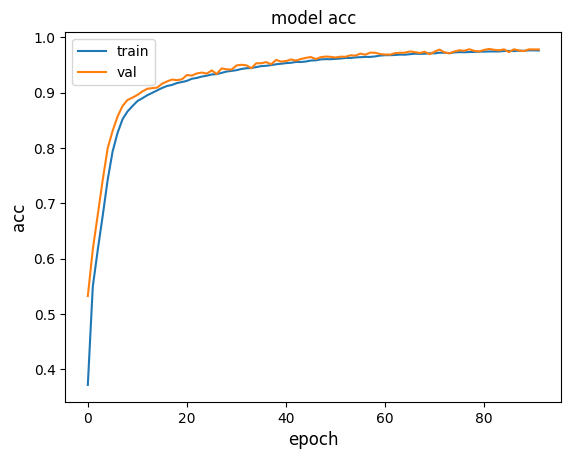

In [8]:
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
import matplotlib.pyplot as plt
metric = "acc"
plt.figure()
plt.plot(history.history[metric], label="train")
plt.plot(history.history["val_" + metric], label="val")
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend()
plt.show()
plt.close()

In [ ]:
model.save(r'C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\models\freq_all_std_force_quality\LTSM_freq.h5', save_format="h5")

1491/1491 [==============================] - 5s 3ms/step


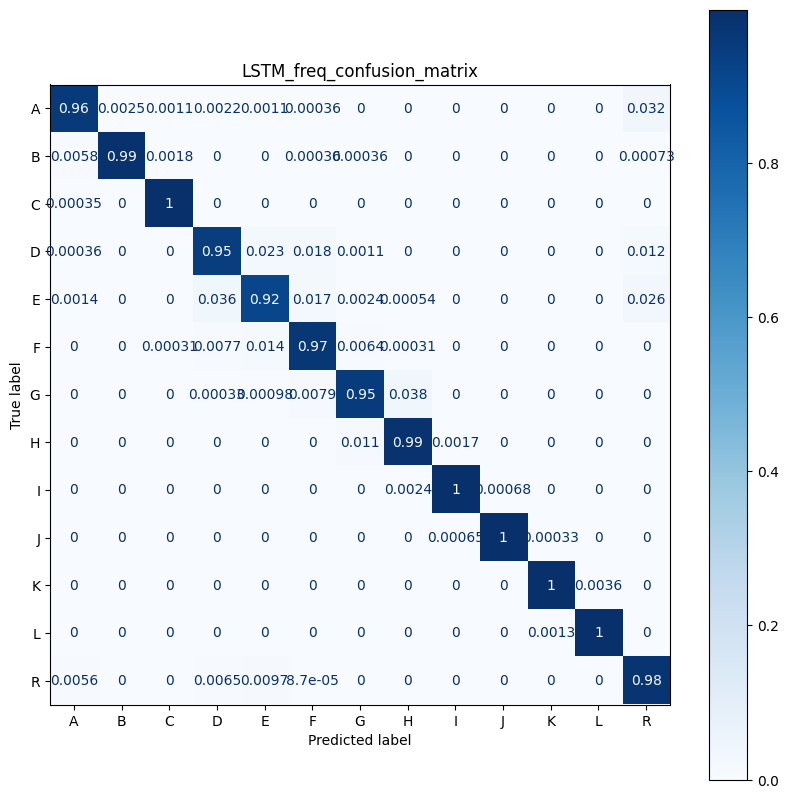

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
y_pred = model.predict([signal_x_test, temp_x_test])
y_pred = np.argmax(y_pred, axis = 1)
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=lb.inverse_transform(range(0, 13)),
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax
)
disp.ax_.set_title("LSTM_freq_confusion_matrix")

plt.show()

In [ ]:
signal_x_train.shape

In [ ]:
x_train